<!--HEADER-->
*[Guia de aulas da disciplina de Modelagem Matemática](https://github.com/rmsrosa/modelagem_matematica) do [IM-UFRJ](https://www.im.ufrj.br).*

<!--NAVIGATOR-->

<a href="https://colab.research.google.com/github/rmsrosa/modelagem_matematica/blob/master/aulas/19.00-Aula19.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>
&nbsp;
<a href="https://mybinder.org/v2/gh/rmsrosa/modelagem_matematica/master?filepath=aulas/19.00-Aula19.ipynb"><img align="left" src="https://mybinder.org/badge.svg" alt="Open in binder" title="Open and Execute in Binder"></a>
&nbsp;
<a href="https://rmsrosa.github.io/modelagem_matematica/aulas/19.00-Aula19.slides.html"><img align="left" src="https://rmsrosa.github.io/jupyterbookmaker/badges/slides_badge.svg" alt="Open slides" title="Open and View Slides"></a>
&nbsp;

[<- Aula 18: Transformada de Radon, suas generalizações e raio-X](18.00-Aula18.ipynb) | [Página Inicial](00-Sumario.ipynb) | [Aula 20: Retroprojeção não-filtrada ->](20.00-Aula20.ipynb)

---


# Aula 19: Inversão da transformada de Radon e recuperação de imagens

## Objetivos

- Sinograma
- Inversão da transformada de Radon e recuperação de imagens via
    - Transformada de Fourier
    - Retroprojeção não-filtrada
    - Retroprojeção filtrada
- Referências:
    - [K. Bolles, "The Mathematics of Medical Imaging, inverting the Radon transform", Senior Project](https://www.whitman.edu/Documents/Academics/Mathematics/SeniorProject_KaileyBolles.pdf) (principal, bem sucinta e clara)
    - [P. A. Toft, "The Radon Transform - Theory and Implementation", Kgs. Lyngby, Denmark: Technical University of Denmark (DTU), 1996](http://orbit.dtu.dk/en/publications/the-radon-transform--theory-and-implementation(7910dc8d-5b65-4c90-ac4b-c94c67d06f01).html).
    - [J. Beatty, "The Radon Transform and the Mathematics of Medical Imaging", Honor Theses, Digital Commons @ Colby, 2012](http://digitalcommons.colby.edu/honorstheses/646).

    

In [1]:
from os import path

import numpy as np
from scipy.integrate import quad
from scipy.interpolate import interp1d, interp2d

import matplotlib.pyplot as plt

import io, base64
from IPython.display import Image, HTML

def path_files_raiosx(filename):
    return path.join('..', 'dados', 'raiosx', filename)

## Relembrando a transformada de Radon

Se $f(x,y)$ indica uma função de densidade de um corpo ocupando uma região bidimensional limitada $(x,y)\in \Omega\subset \mathbb{R}^2$, com $f=0$ no complementar, vimos que a **transformada de Radon** de f é uma função que leva qualquer reta $L$ em $\mathbb{R}^2$ no valor da integral de linha

$$ Rf(L) = \int_L f(\mathbf x) |\rm d \mathbf x|.
$$

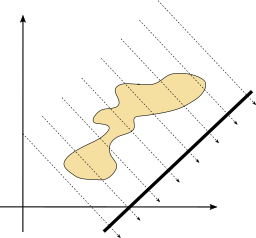

In [2]:
Image(path_files_raiosx('radon_transform.png'))

### Transformada de Radon em termos de uma parametrização das retas

Em $\mathbb{R}^2$, cada reta $L$ pode ser parametrizada da forma $\sigma(s) = (x(s), y(s))$ pela distância $t$ da reta à origem e pelo ângulo $\theta$ normal à reta, no sentido da origem à reta:

$$ \begin{cases}
  x(s) = t\cos\theta - s\sin\theta, \\
  y(s) = t\sin\theta + s\cos\theta.
\end{cases}
$$
Essa é uma parametrização pelo comprimento de arco. Assim,

$$ Rf(t,\theta) = \int_{-\infty}^\infty f(t\cos\theta - s\sin\theta, t\sin\theta + s\cos\theta) \;\rm d s
$$

### Implementação da função transformada de Radon via scipy.quad

Uma implementação pode ser obtida usando-se algum método de integração do pacote `scipy`. O método `scipy.quad` é um bom candidato, pois nele podemos implementar integrais indefinidas, com o intervalo de integração de $-\infty$ a $+\infty$. 

Mesmo que a integral seja definida, já que assumimos $f$ de suporte limitado, facilita a implementação não precisarmos informar, ou deixar a função transformada de Radon calcular, o intervalo de integração. 

O preço, por isso, é uma lentidão maior no cáculo da transformada ou avisos de falta de convergência do método.

In [3]:
def Radon(f):
    @np.vectorize
    def radon_f(t,theta):
        g = lambda s: f(t*np.cos(theta) - s*np.sin(theta), t*np.sin(theta) + s*np.cos(theta))
        return quad(g, -np.inf, np.inf, epsabs=1.49e-02)[0] 
    return radon_f
print(type(Radon))

<class 'function'>


### Implementação da transformada de Radon via somatório de Riemman

Outra implementação, mais direta, é simplesmente fazer um somatório de Riemann. 

In [4]:
def Radon_Riemman(f, smin = -10, smax = 10, Ns=200):
    @np.vectorize
    def radon_f(t, theta):
        ds = (smax - smin)/Ns
        g = [f(t*np.cos(theta) - s*np.sin(theta), t*np.sin(theta) + s*np.cos(theta)) for s in np.arange(smin, smax, ds)]
        return sum(g)*ds
    return radon_f
print(type(Radon_Riemman))

<class 'function'>


## Sinograma

Na última aula, fixamos um ângulo e construímos o "raio X" variando apenas a distância $t$. Nesse caso, conhecíamos a função $f$ e queríamos obter o filme obtido com um família de feixes paralelos de raio X.

Para o processo inverso, de **tomografia computadorizada**, a ideia é dispormos de uma família mais extensa de "filmes" de raio X, em diversos ângulos, e reconstruírmos  a função $f$.

Essa família mais extensa de valores $Rf(t,\theta)$ da transformada de Radon, para intervalos tanto em $t$ como em $\theta$, gera o que se chama de **sinograma**.

### Exemplo de sinograma

Considere o seguinte corpo formado por dois quadrados concêntricos com densidades diferentes.

In [5]:
@np.vectorize
def f_quadrados(x,y):
    return np.where(max(x**2,y**2) < 0.25, 10, 0) - np.where(max(x**2,y**2) < 0.04, 6, 0)

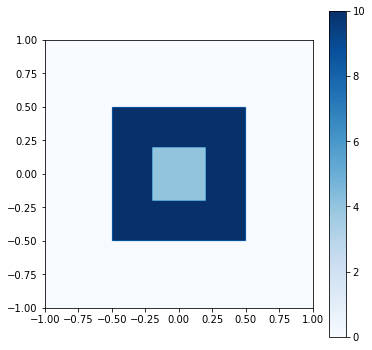

In [6]:
x = y = np.arange(-1, 1, 0.01)
X, Y = np.meshgrid(x,y)
Z = f_quadrados(X,Y)

plt.figure(figsize=(6,6))
im = plt.imshow(Z, interpolation='bilinear', cmap=plt.cm.Blues,
               origin='lower', extent=[-1.0, 1.0, -1.0, 1.0],
               vmin=Z.min(), vmax=Z.max())
plt.colorbar(im)
plt.show()

### Visualizando o sinograma

Considerando a região $(t,\theta) \in [-1,1]\times [0,\pi]$ para o cálculo da transformada de Radon, obtemos a seguinte visualização.

In [7]:
t = np.arange(-1, 1, 0.1)
theta = np.arange(0.0, np.pi, 0.05)

T, Theta = np.meshgrid(t, theta)

g = Radon(f_quadrados)

f_quadrados_sinograma = g(T, Theta)

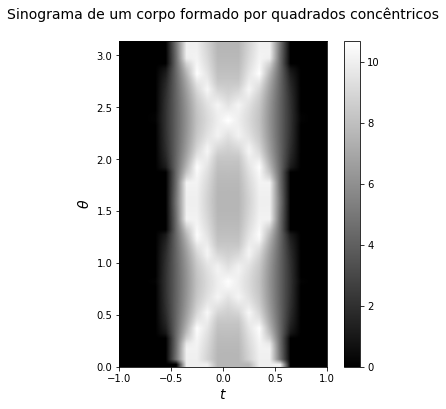

In [8]:
plt.figure(figsize=(6,6))
im = plt.imshow(f_quadrados_sinograma, interpolation='bilinear', cmap=plt.cm.gray,
               origin='lower', extent=[-1.0, 1.0, 0.0, np.pi],
               vmin=f_quadrados_sinograma.min(), vmax=f_quadrados_sinograma.max())
plt.xlabel(r'$t$', fontsize=14)
plt.ylabel(r'$\theta$', fontsize=14)
plt.title('Sinograma de um corpo formado por quadrados concêntricos\n', fontsize=14)
plt.colorbar(im)
plt.show()

### Implementação direta do sinograma

A visualização acima foi obtida com a transformada de Radon implementada via `scipy.quad`. 

Podemos fazer uma versão utilizando a versão com soma de Riemann. E isso pode ser feito mais rapidamente definindo uma nova função `sinograma` em python que inclui o somatório diretamente, ao invés de chamar a transformada de Radon definida acima.

Isso é feito no código a seguir.

In [9]:
def sinograma(f, xmin, xmax, ymin, ymax, 
              Nt = 200, thetamin = 0, thetamax = np.pi, Ntheta = 200, Ns = 200):
    tmin = min(xmin, ymin)
    tmax = max(xmax, ymax)
    dt = (tmax - tmin)/Nt
    t = np.arange(tmin, tmax, dt)
    dtheta = (thetamax - thetamin)/Ntheta
    theta = np.arange(thetamin, thetamax, dtheta)
    smax = np.sqrt((xmax-xmin)**2 + (ymax-ymin)**2)
    smin = -smax
    ds = (smax - smin)/Ns
    sinterval = np.arange(smin, smax, ds)
    T, Theta = np.meshgrid(t, theta)
    sino = sum([f(T*np.cos(Theta) - s*np.sin(Theta), T*np.sin(Theta) + s*np.cos(Theta))*ds for s in sinterval])
    return sino

print(type(sinograma))

<class 'function'>


In [10]:
f_quadrados_sinograma_riemman = sinograma(f_quadrados, -1.0, 1.0, -1.0, 1.0)

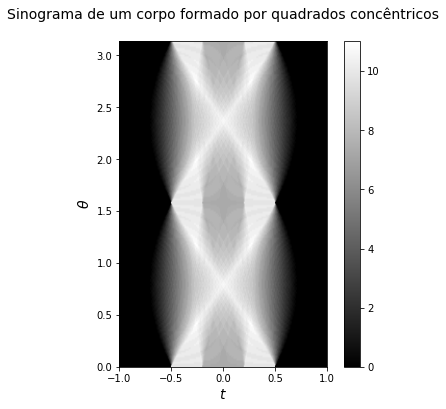

In [11]:
plt.figure(figsize=(6,6))
im = plt.imshow(f_quadrados_sinograma_riemman, interpolation='bilinear', cmap=plt.cm.gray,
               origin='lower', extent=[-1.0, 1.0, 0.0, np.pi],
               vmin=f_quadrados_sinograma_riemman.min(), vmax=f_quadrados_sinograma_riemman.max())
plt.xlabel(r'$t$', fontsize=14)
plt.ylabel(r'$\theta$', fontsize=14)
plt.title('Sinograma de um corpo formado por quadrados concêntricos\n', fontsize=14)
plt.colorbar(im)
plt.show()

## Origem do nome sinograma

### Corpo pontual

Se o corpo está concentrado em um ponto $(x_*,y_*)$ fora da origem, com massa $1$, podemos representá-lo pela função delta de Dirac,

$$ f(x,y) = \delta_{(x_*,y_*)}(x,y).
$$

Esta não é exatamente uma função no sentido clássico. Ela é um exemplo de uma **distribuição**, que é um operador que leva uma função suave $g(x,y)$ em

$$ \langle f, g \rangle = g(x_*, y_*). 
$$

A notação $\langle f, g\rangle$ denota a aplicação da distribuição $f$ na função $g$. Ela é uma generalização do produto escalar em $L^2(\mathbb{R}^2)$ (nesse caso bidimensional, já que a teoria de distribuições se aplica a qualquer dimensão). Mesmo  $f$ não sendo integrável, é comum mantermos a representação integral para $\langle f, g \rangle = (f,g)_{L^2(\mathbb{R}^2)}$, apesar de não ser propriamente uma integral.

Caso $f$ também fosse suave, teríamos

$$ \langle f, g \rangle = \iint_{\mathbb{R}^2} f(x,y) g(x,y) \;{\rm d} x \;{\rm d} y
$$

No caso em que $f$ não é uma função integrável, é comum mantermos a representação integral, apesar de não ser propriamente uma integral.

### Transformada de Radon com notação de distribuição

Denotando por $\delta$ a função delta de Dirac unidimensional com massa pontual na origem, ou seja, 

$$\langle \delta, g\rangle = g(0),
$$ 

para uma função $g=g(x)$ unidimensional, podemos escrever a transformada de Radon na forma

$$ \begin{multline*} 
  Rf(t, \theta) = \int_{-\infty}^\infty f(t\cos\theta - s\sin\theta, t\sin\theta + s\cos\theta) \;{\rm d} s \\ = \iint_{\mathbb{R}^2} f(r\cos\theta - s\sin\theta, r\sin\theta + s\cos\theta)\delta(r-t) \;{\rm d} r\, {\rm d} s
  \end{multline*}
$$

No caso em que $f(x,y) = \delta_{(x_*,y_*)}(x,y)$, podemos escrever, utilando a delta de Dirac unidimensional,

$$ f(x,y) = \delta_{(x_*,y_*)}(x,y) = \delta(x-x_*)\delta(y-y_*).
$$

Assim, a transformada de Radon de $f$ nos dá

$$ \begin{multline*} 
  Rf(t, \theta) = \iint_{\mathbb{R}^2} \delta(r\cos\theta - s\sin\theta)\delta(r\sin\theta + s\cos\theta)\delta(r-t) \;{\rm d} r\, {\rm d} s
  \end{multline*} \\ = \int_{-\infty}^\infty \delta(t\cos\theta - s\sin\theta)\delta(t\sin\theta + s\cos\theta) \;{\rm d} s
$$

### Sinograma de um corpo pontual

No caso em que $f(x,y) = \delta_{(x_*,y_*)}(x,y)$, temos, então, que

$$ Rf(t, \theta) = \int_{-\infty}^\infty f(t\cos\theta - s\sin\theta, t\sin\theta + s\cos\theta) \;{\rm d} s = 1
$$

se, e somente se, 

$$ \exists s\in \mathbb{R}, \; (t\cos\theta - s\sin\theta, t\sin\theta + s\cos\theta) = (x_*, y_*).
$$

Ou seja, se, e somente se,

$$ \begin{cases}
  t\cos\theta - s\sin\theta = x_* \\
  t\sin\theta + s\cos\theta = y_*.
\end{cases}
$$

Multiplicando a primeira equação por $\cos\theta$, a segunda por $\sin\theta$ e somando os resultados obtemos

$$ t = x_*\cos\theta + y_*\sin\theta.
$$

Portanto, $Rf(t,\theta) = 1$ apenas ao longo da senoide determinada pela equação acima (considerando $(x_*,y_*)\neq (0,0)$.

### Exemplo ilustrando a origem do nome sinograma

In [12]:
@np.vectorize
def f_quadrado_deslocado(x,y):
    return np.where(max((x-0.75)**2,(y-0.5)**2) < 0.0025, 10, 0)


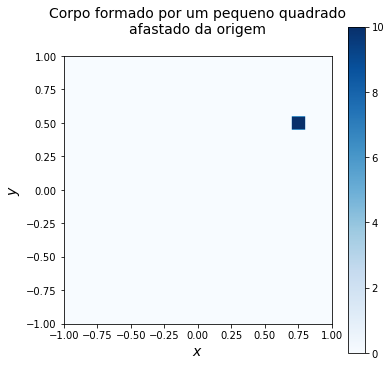

In [13]:
x = y = np.arange(-1, 1, 0.01)
X, Y = np.meshgrid(x,y)
Z = f_quadrado_deslocado(X,Y)

plt.figure(figsize=(6,6))
im = plt.imshow(Z, interpolation='bilinear', cmap=plt.cm.Blues,
               origin='lower', extent=[-1.0, 1.0, -1.0, 1.0],
               vmin=Z.min(), vmax=Z.max())
plt.xlabel(r'$x$', fontsize=14)
plt.ylabel(r'$y$', fontsize=14)
plt.title('Corpo formado por um pequeno quadrado\nafastado da origem\n', fontsize=14)
plt.colorbar(im)
plt.show()

### Visualizando o sinograma

Para uma melhor visualização, vamos exibir o sinograma com um intervalo angular maior e com o ângulo na abscissa e a distância até a origem na ordenada.

In [14]:
f_quadrado_deslocado_sinograma = sinograma(f_quadrado_deslocado, -1.0, 1.0, -1.0, 1.0, thetamin=0, thetamax=2*np.pi, Ns=100)

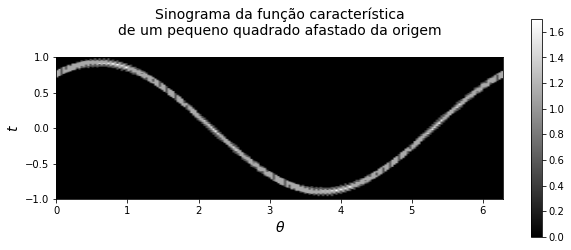

In [15]:
plt.figure(figsize=(10,4))
im = plt.imshow(f_quadrado_deslocado_sinograma.T, interpolation='bilinear', cmap=plt.cm.gray,
               origin='lower', extent=[0, 2*np.pi, -1.0, 1.0],
               vmin=f_quadrado_deslocado_sinograma.min(), vmax=f_quadrado_deslocado_sinograma.max())
plt.xlabel(r'$\theta$', fontsize=14)
plt.ylabel(r'$t$', fontsize=14)
plt.title('Sinograma da função característica\nde um pequeno quadrado afastado da origem\n', fontsize=14)
plt.colorbar(im)
plt.show()

## Invertendo a transformada de Radon

De grande aplicação médica, assim como em diversas outras áreas, é o processo inverso, de reconstrução da função $f=f(x,y)$, a partir do seu sinograma $Rf(t,\theta)$.

A busca por algoritmos eficientes e precisos de inversão é uma área de pesquisa bastante ativa.

Há dois métodos importantes que vamos considerar:

- Via transformadas de Fourier e o teorema da fatia de Fourier (*Fourier slice theorem*)

- Retroprojeção filtrada (*filtered backprojection*).


### Invertendo via transformadas de Fourier

A transformada de Fourier **n-dimensional** de uma função $f=f(\mathbf{x})$, $\mathbf{x}\in \mathbb{R}^n$ é dada por

$$ (\mathcal{F}_n f)(\mathbf{\xi}) = \int_{\mathbb{R}^n} f(\mathbf{x})e^{i\pi \mathbf{x}\cdot\mathbf{\xi}} \;\rm d \mathbf{\xi}
$$

Denotando $R_\theta f(t) = Rf(t,\theta)$, o **Teorema da fatia de Fourier** diz que

$$ (\mathcal{F}_1 (R_\theta f))(s) = (\mathcal{F}_2 f)(s\cos\theta, s\sin\theta),
$$

Em coordenadas polares, sendo $(\xi,\eta) = (s\cos\theta, s\sin\theta)$, temos $s=\|(\xi,\eta)\| = \sqrt{\xi^2+\eta^2}$, de forma que

$$  (\mathcal{F}_2 f)(\xi,\eta) = (\mathcal{F}_1 (R_\theta f))(\|(\xi,\eta)\|)
$$

Assim, conhecendo-se $Rf(t,\theta) = R_\theta f(t)$, podemos obter $f(x,y)$ através da transformada inversa bidimensional de Fourier da função $(\xi,\eta) \mapsto (\mathcal{F}_1 (R_\theta f))(\|(\xi,\eta)\|)$, nos dando a seguinte fórmula para a **transformada inversa de Radon** via transformadas de Fourier:

$$ f = \mathcal{F}_2^{-1} (\mathcal{F}_1 (R_\theta f)\circ \|(\cdot, \cdot)\|)
$$


### Aproximando a inversão via Retroprojeção não-filtrada

Uma maneira de se obter uma aproximação da função $f$ é via o chamado método de retroprojeção (neste momento, sem filtro), que é obtida a partir da adjunto da transformada de Radon.

A **adjunta** da transformada de Radon é a transformada que leva uma dada função $h=h(t,\theta)$ em

$$ (\mathcal{R}^*h)(x,y) = \frac{1}{\pi}\int_0^\pi h(x\cos\theta + y\sin\theta, \theta) \;\rm d \theta.
$$

Temos a propriedade de $\mathcal R$ e $\mathcal R^*$ serem adjuntas em espaços apropriados:

$$ \begin{multline*}
 \langle \mathcal{R}f, h \rangle_{\pi^{-1}L^2(\mathbb{R}\times S_1)} = \frac{1}{\pi} \int_0^\pi \int_0^\pi \mathcal{R}(f)(t,\theta) h(t, \theta) \;\rm d t\, \rm d \theta \\ = \iint_{\mathbb{R}^2} f(x,y) (\mathcal{R}^*h)(x,y) \;\rm d x \; \rm d y = \langle f, \mathcal{R}^*h\rangle_{L^2(\mathbb{R}^2)}
 \end{multline*}
$$

Aplicando-se a adjunta à transformada de Radon de uma função $f=f(x,y)$, obtemos a **retroprojeção não-filtrada**

$$ (\mathcal{B}f)(x,y) = (\mathcal{R}^*(\mathcal{R}f)) = \frac{1}{\pi}\int_0^\pi (Rf)(x\cos\theta + y\sin\theta, \theta) \;\rm d \theta.
$$


### Interpretação da retroprojeção não-filtrada

Temos
$$ (\mathcal{R}^*h)(x,y) = \frac{1}{\pi}\int_0^\pi h(x\cos\theta + y\sin\theta, \theta) \;\rm d \theta.
$$

Isso é, para cada para $(x,y)$ uma média de $h=h(t,\theta)$ ao longo da senoide $t = x\cos\theta + y\sin\theta$.

Por sua vez, a retroprojeção não-filtrada é

$$ (\mathcal{B}f)(x,y) = (\mathcal{R}^*(\mathcal{R}f)) = \frac{1}{\pi}\int_0^\pi (Rf)(x\cos\theta + y\sin\theta, \theta) \;\rm d \theta.
$$

Como $\mathcal{R}f(t,\theta)$ para cada $t=x\cos\theta + y\sin\theta$ é a integral de $f=f(x,y)$ ao longo da reta que passa por $(x,y)$ e cuja normal tem inclinação dada pelo ângulo $\theta$, vemos que $(\mathcal{B}f)(x,y)$ é a média da transformada de Radon de $f$ em relação a todas as retas que passam pelo ponto $(x,y)$.


### Retroprojeção filtrada

A retroprojeção não-filtrada não dá bons resultados, é apenas uma aproximação grosseira. Mas incorporando uma espécie de filtro, obtemos um resultado muito melhor.

Dado um "filtro" $K=K(t, \theta)$, a retroprojeção filtrada associada a $K$ é a transformada

$$ (\mathcal{B}_K f)(x,y) = \frac{1}{\pi}\int_0^\pi \int_{-\infty}^\infty (\mathcal{R}f)(t - x\cos\theta - y\sin\theta, \theta) K(t, \theta)\;{\rm d} t \,{\rm d} \theta.
$$

Expandindo $\mathcal{R}f$, temos
$$ \begin{multline*}
  (\mathcal{B}_K f)(x,y) = \frac{1}{\pi}\int_0^\pi \int_{-\infty}^\infty \int_{-\infty}^\infty \\ f((t - x\cos\theta - y\sin\theta)\cos \theta - s\sin\theta, (t - x\cos\theta - y\sin\theta)\sin\theta + s\cos\theta) K(t, \theta) \\\;{\rm d} s \,{\rm d} t \,{\rm d} \theta.
  \end{multline*}
$$

Ao utilizarmos a adjunta da transformada de Radon, podemos reescrever a expressão acima como uma integral envolvendo $f$ e $\mathcal{R}^*K$.

Utilizando $K$ tal que $\mathcal{R}^*K$ esteja próximo de uma delta de Dirac deslocada para pontos $(x,y)$, obtemos que a expressão está próxima de $f(x,y)$.

### Retroprojeção com uma família apropriada de filtros 

Usando uma família de filtros $\Gamma_z$, $z\in \mathbb{R}$, satisfazendo $\mathcal{R}^*\Gamma_z = \gamma_z$, onde

$$ \gamma_z(\xi, \eta) = \frac{1}{\pi z^2}\chi_{B(0, z)}(\xi, \eta),
$$

obtemos a seguinte fórmula para a **inversa da transformada de Radon** via retroprojeção filtrada:

$$ \begin{multline*}
  f(x,y) = (\mathcal{R}^{-1}f)(x,y) = \lim_{z\rightarrow 0} \mathcal{B}_{\Gamma_z} f \\ 
= \frac{1}{\pi}\lim_{z\rightarrow 0} \int_0^\pi \int_{-\infty}^\infty (\mathcal{R}f)(t - x\cos\theta - y\sin\theta, \theta) \Gamma_z(t)\;\rm d t \;\rm d \theta
\end{multline*}
$$

### Sobre o filtro

O filtro $\Gamma_z$ que satisfaz 

$$\mathcal{R}^*\Gamma_z = \gamma_z = \frac{1}{\pi z^2}\chi_{B(0,z)}
$$ 

é dado por

$$ \Gamma_z(t, \theta) = \frac{1}{\pi z^2}\begin{cases}
    1, & |t| \leq |z|, \\
    \displaystyle 1 - \frac{1}{\sqrt{1 - z^2/t^2}}, & |t|> |z|.
  \end{cases}
$$

Outros filtros podem ser utilizados, desde que formem uma família convergindo para a  função delta de Dirac (aproximações da identidade).

Na prática, utiliza-se $z$ "pequeno" o suficiente para uma "boa" aproximação. Ou algum outro filtro que seja uma "boa" aproximação da delta de Dirac.

### Exemplificando as retroprojeções filtradas e não-filtradas

Os exemplos abaixo são do texto [K. Bolles, "The Mathematics of Medical Imaging, inverting the Radon transform", Senior Project](https://www.whitman.edu/Documents/Academics/Mathematics/SeniorProject_KaileyBolles.pdf).

A imagem original é a seguinte:

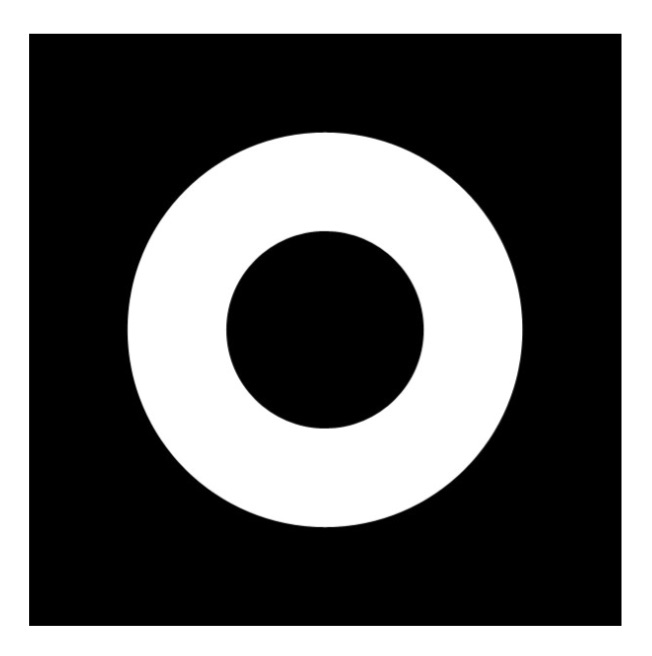

In [16]:
Image(path_files_raiosx('E_original.jpg'), width=400)

### Transformada de Radon da imagem

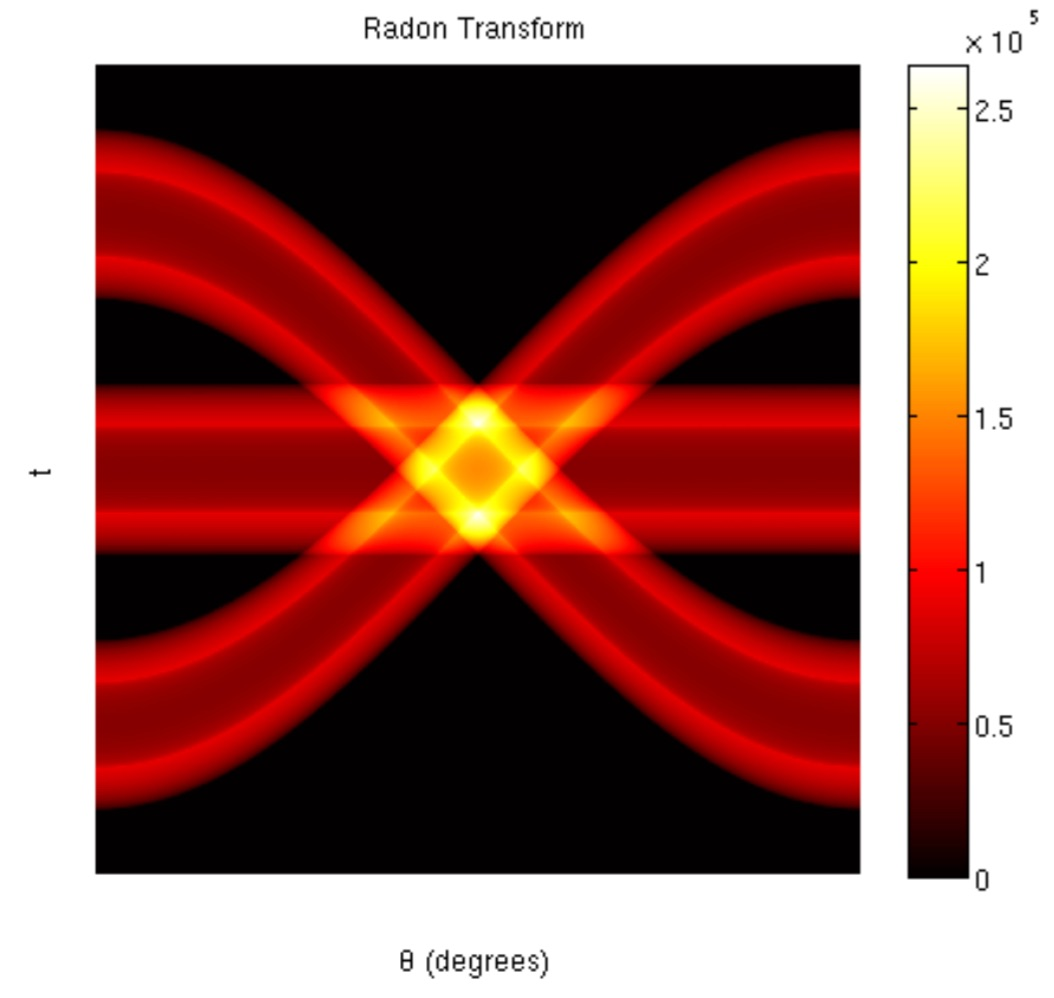

In [17]:
Image(path_files_raiosx('E_RadonTransformed.jpg'), width=400)

### Retroprojeção não-filtrada

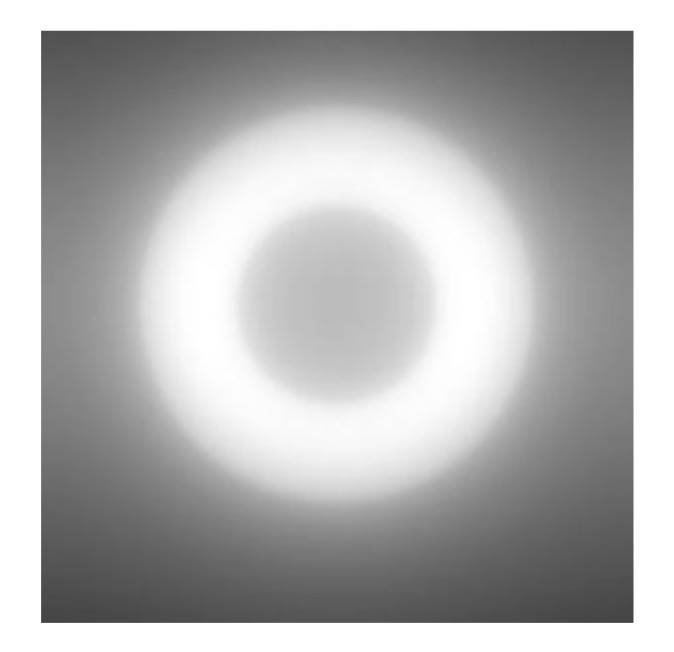

In [18]:
Image(path_files_raiosx('E_unfiltered_backprojection.jpg'), width=400)

### Retroprojeção filtrada usando partição de $[0,\pi]$ com 18 e 36 ângulos 

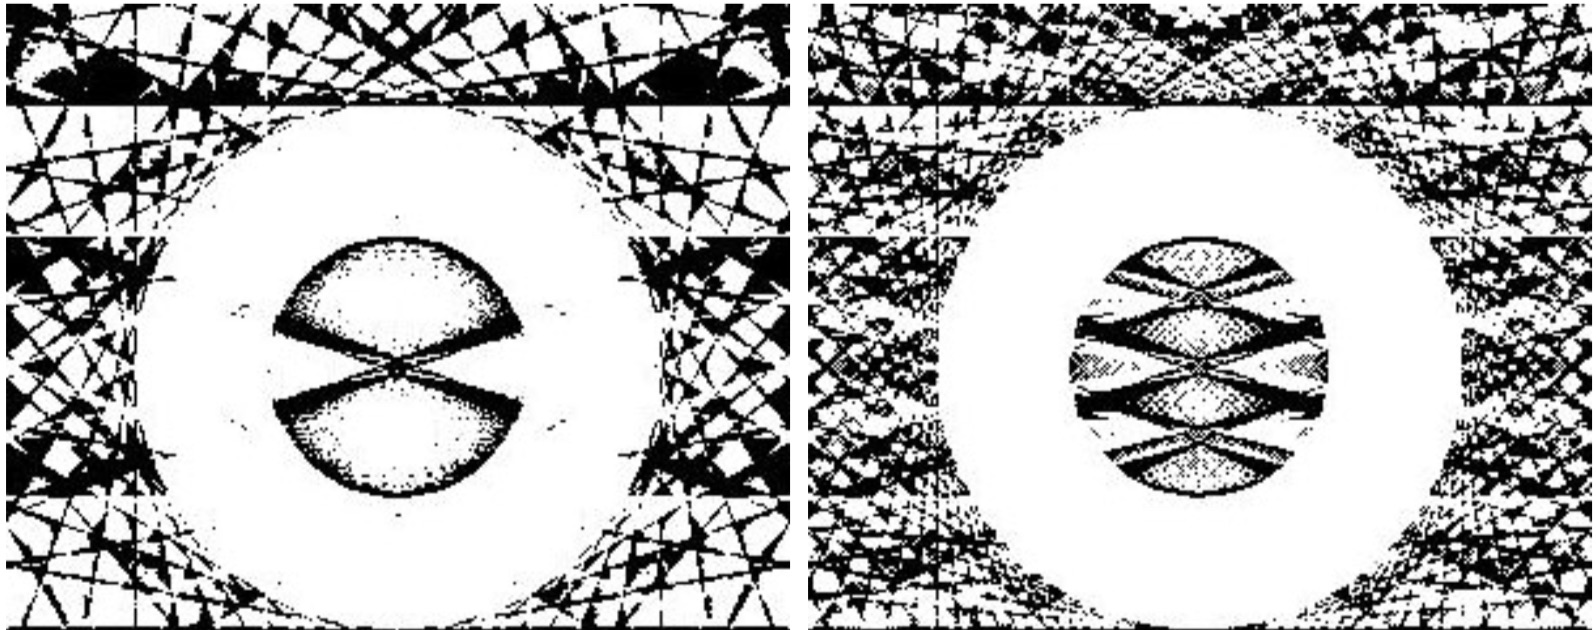

In [19]:
Image(path_files_raiosx('E_filtered_backprojection_18and36angles.jpg'), width=650)

### Retroprojeção filtrada usando partição de $[0,\pi]$ com 90 e 180 ângulos 

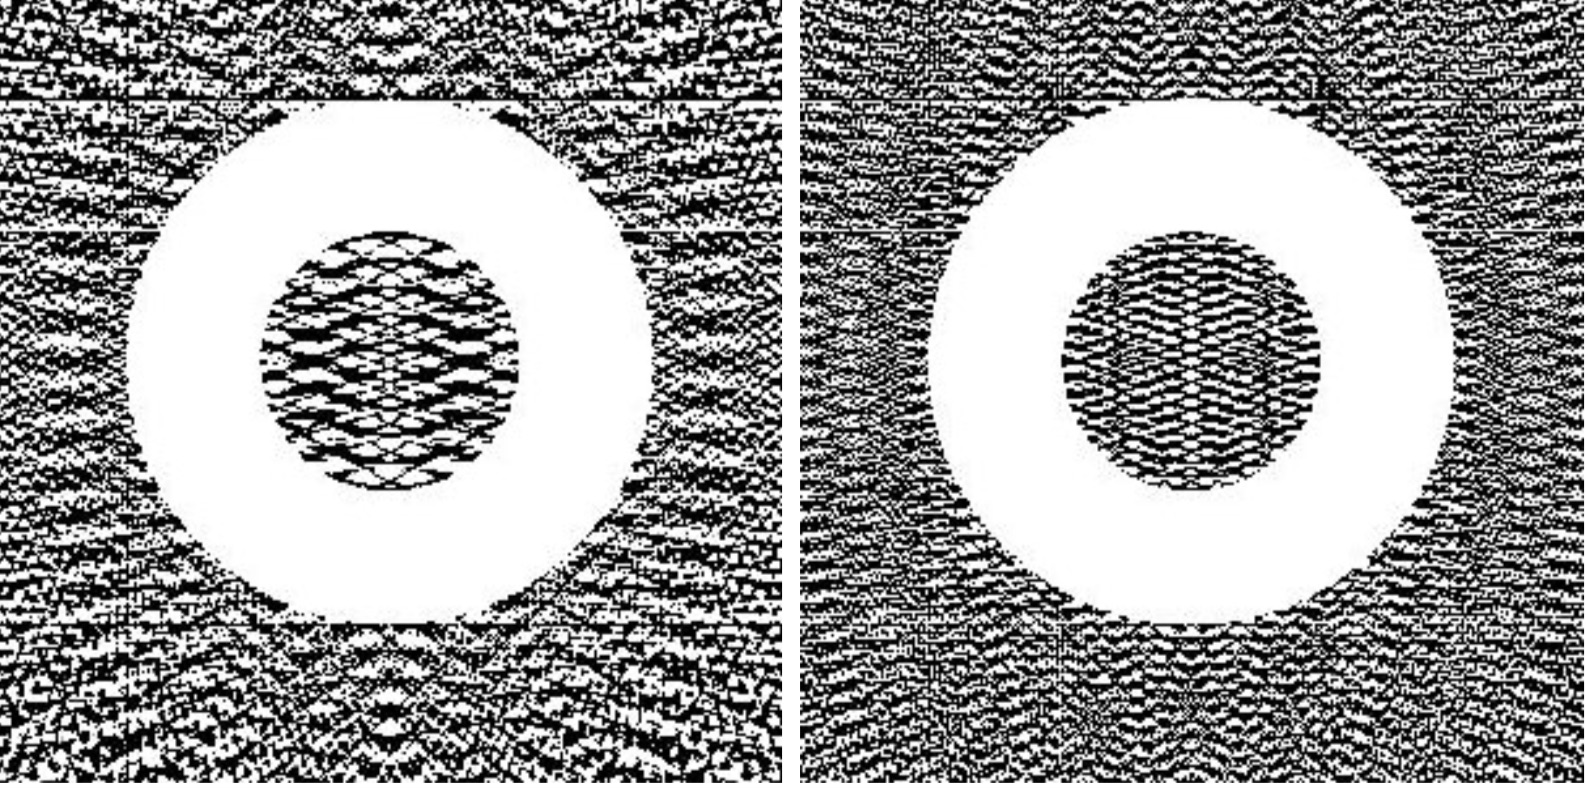

In [20]:
Image(path_files_raiosx('E_filtered_backprojection_90and180angles.jpg'), width=650)

### Retroprojeção filtrada usando partição de $[0,\pi]$ com 360 e 720 ângulos 

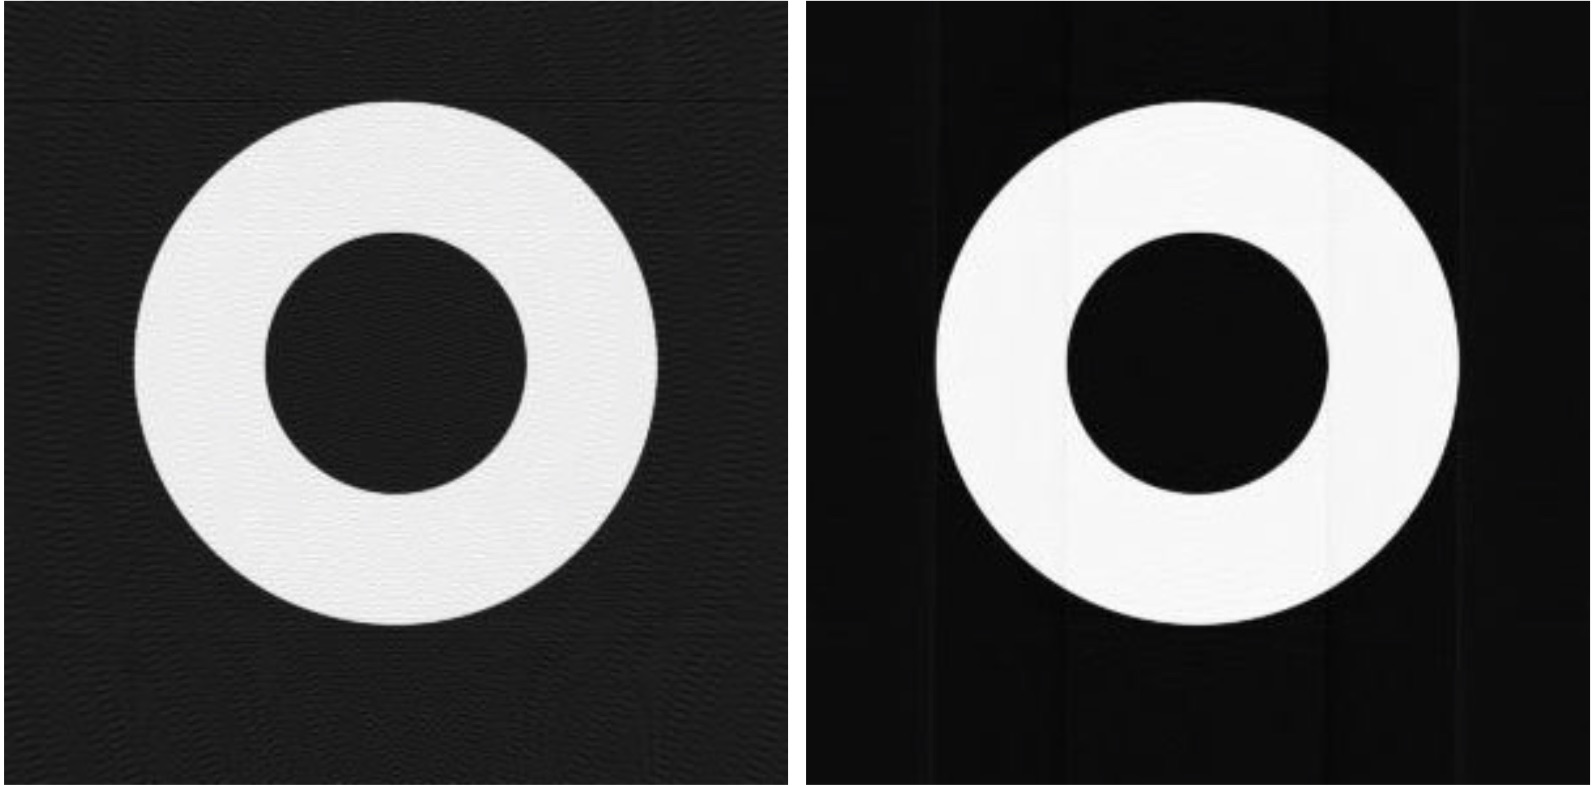

In [21]:
Image(path_files_raiosx('E_filtered_backprojection_360and720angles.jpg'), width=650)


## Exercícios

1. Implementar a retroprojeção não-filtrada.

1. Implementar a retroprojeção filtrada com partição angular variável.

1. Implementar diferentes filtros na retroprojeção filtrada.

1. Aplicar as retroprojeções na imagem sintética clássica, usada na análise de métodos de tomografia, conhecida como [Shepp–Logan phantom head](https://en.wikipedia.org/wiki/Shepp–Logan_phantom).



---

### Apresentação em slides

In [23]:
!jupyter nbconvert 19.00-Aula19.ipynb --to slides --SlidesExporter.reveal_scroll=True --template output_toggle.tpl

[NbConvertApp] Converting notebook 19.00-Aula19.ipynb to slides
[NbConvertApp] Writing 1994311 bytes to 19.00-Aula19.slides.html


<!--NAVIGATOR-->

---
[<- Aula 18: Transformada de Radon, suas generalizações e raio-X](18.00-Aula18.ipynb) | [Página Inicial](00-Sumario.ipynb) | [Aula 20: Retroprojeção não-filtrada ->](20.00-Aula20.ipynb)

<a href="https://colab.research.google.com/github/rmsrosa/modelagem_matematica/blob/master/aulas/19.00-Aula19.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>

<a href="https://mybinder.org/v2/gh/rmsrosa/modelagem_matematica/master?filepath=aulas/19.00-Aula19.ipynb"><img align="left" src="https://mybinder.org/badge.svg" alt="Open in binder" title="Open and Execute in Binder"></a>

<a href="https://rmsrosa.github.io/modelagem_matematica/aulas/19.00-Aula19.slides.html"><img align="left" src="https://rmsrosa.github.io/jupyterbookmaker/badges/slides_badge.svg" alt="Open slides" title="Open and View Slides"></a>
&nbsp;